<div class="alert alert-block alert-success">
<b>NOTEBOOK 1 - Data Structural Cleanup
</div>

---
# 1 - IMPORTS

### 1.1 - SETUP PROJECT

Make sure to check `README.md` and `requirements.txt` before running any notebooks. 

In [ ]:
# Import modules
import sys
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

### 1.2 - DEFINE PATHS

In [202]:
# Paths
PROJECT_PATH = Path.cwd().resolve().parent
DATA_PATH = PROJECT_PATH / "data"
RAW_DATA_PATH = DATA_PATH / "raw"
META_PATH = DATA_PATH / "meta"
INTERIM_DATA_PATH = DATA_PATH / "interim"
SRC_PATH = PROJECT_PATH / "src"
UTILS_PATH = SRC_PATH / "utilities"
PROCESSED_PATH = DATA_PATH / "processed"

# Add src to sys.path (for package-style imports)
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

# Add utilities folder to sys.path (for direct import utils)
if str(UTILS_PATH) not in sys.path:
    sys.path.append(str(UTILS_PATH))


# Import with reload
try:
    import utilities.utils as utils
except ModuleNotFoundError:
    import utils

reimport = importlib.reload(utils)

### 1.3 - LOAD DATASET

In [203]:
# Load Data

# Clustering
file_path_c = INTERIM_DATA_PATH / "04_climate_dataset_forClustering_unscaled.xlsx"
cluster_df = pd.read_excel(file_path_c, sheet_name=None)["Sheet1"]

# Descriptive stats
file_path_d = INTERIM_DATA_PATH / "04_climate_dataset_descriptive_features.xlsx"
desc_df = pd.read_excel(file_path_d, sheet_name=None)["Sheet1"]

# Display both
display(cluster_df.head())
display(desc_df.head()) 

,environmental_concerns,adaptation_engagement_score,climate_event_count,flood_experience,heat_experience,climate_consequence_count,infra_consequences,health_consequences,climate_concern,personal_preparedness_score,domestic_responsibility,global_solidarity
0,1,4,0,0,0,0,0,0,5,3,3,2
1,1,4,1,0,0,1,0,0,6,4,2,3
2,0,4,2,0,2,0,0,0,5,5,5,3
3,0,3,3,1,1,0,0,0,4,5,1,3
4,0,3,1,0,1,3,1,1,6,3,3,2


,gender,age_group,kids,education,net_income,political_preference,housing_status,living_area
0,0,5,2,2,10,7,2,1
1,0,5,2,3,1,6,1,2
2,1,3,2,2,1,10,2,3
3,0,3,2,3,11,5,2,2
4,1,3,2,3,9,12,2,1


---
# 2 - EDA & PREPROCESSING

### 2.1 - SCALING CLUSTER FEATURES & EDA

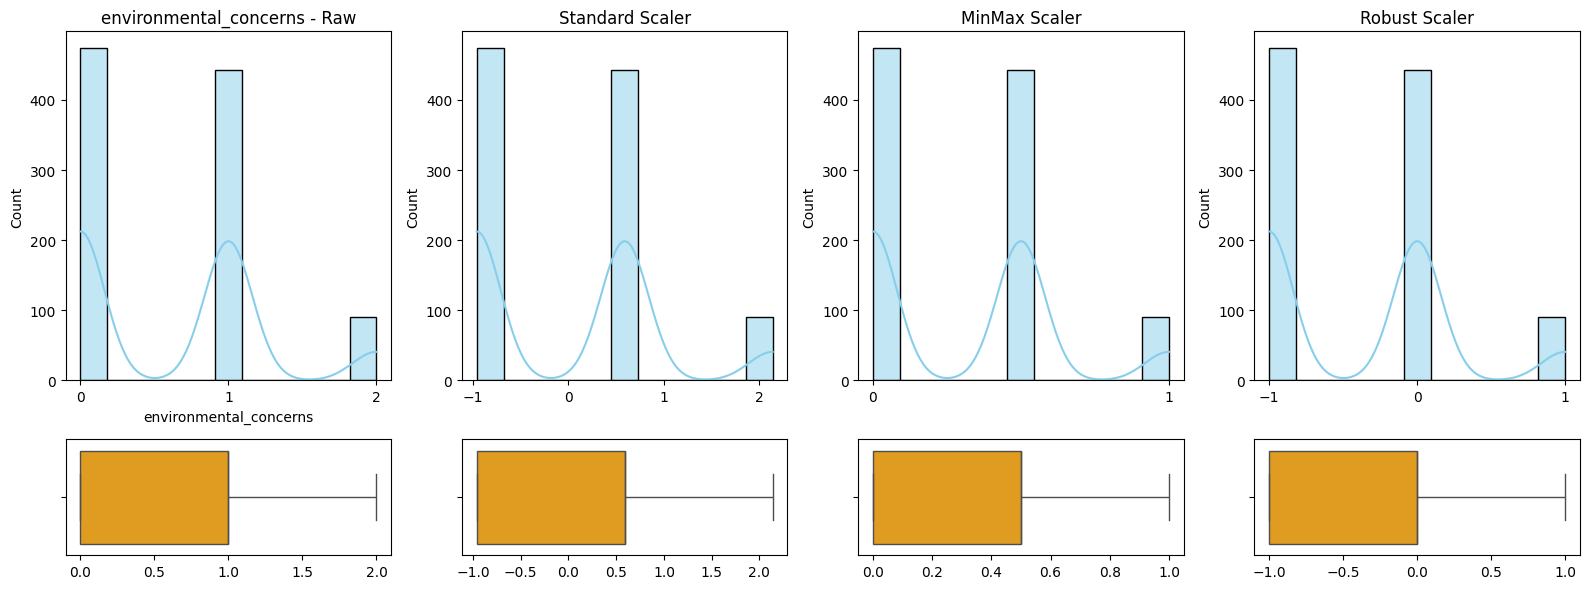

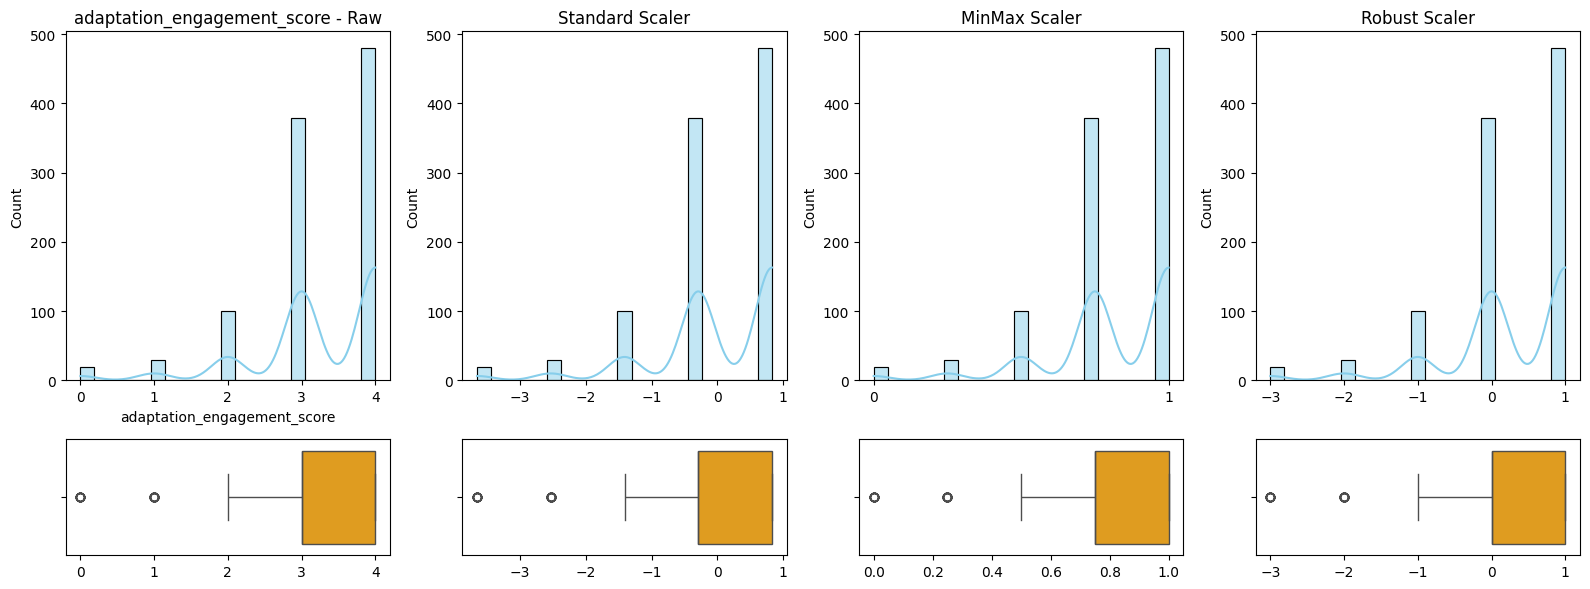

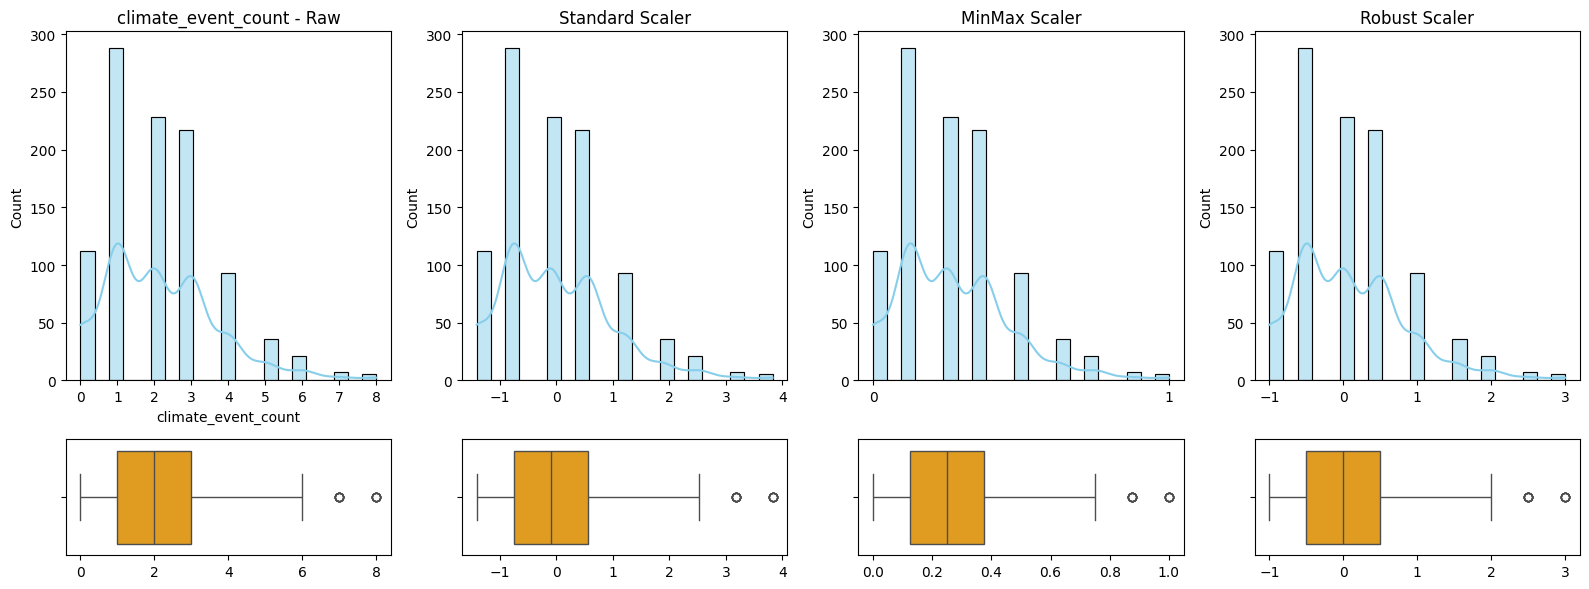

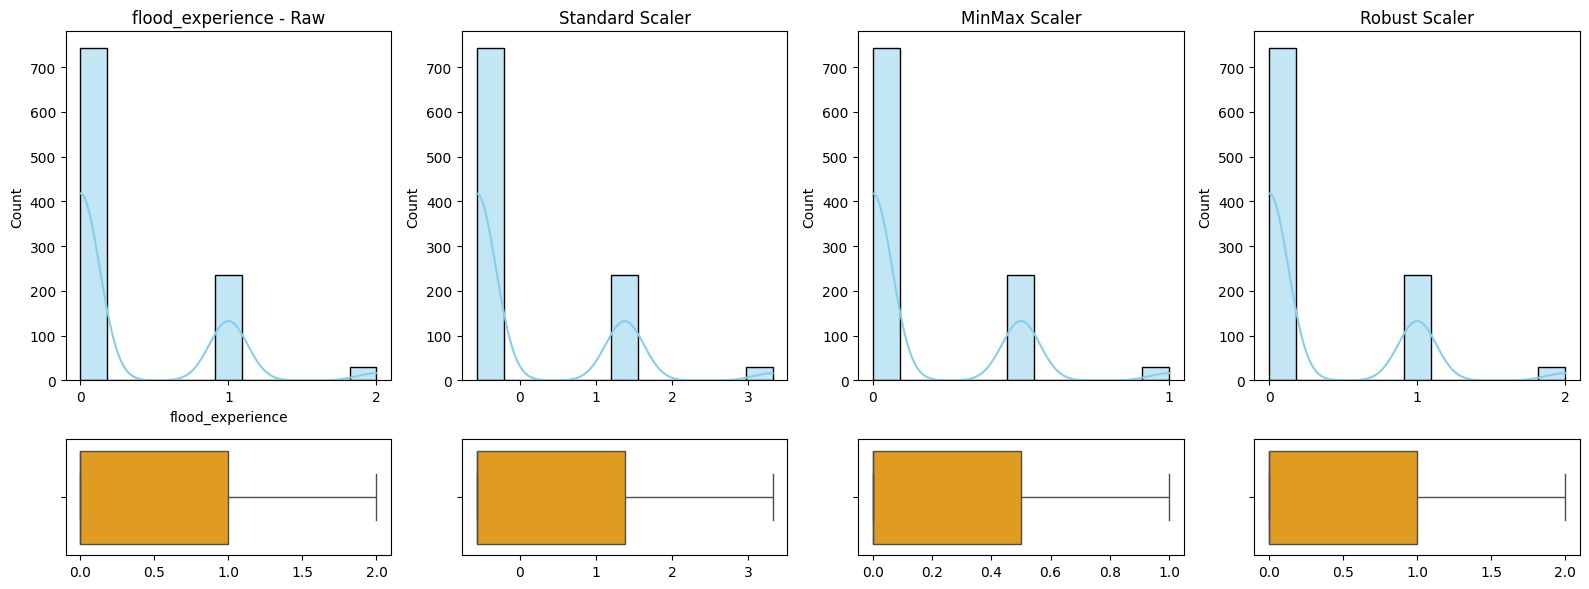

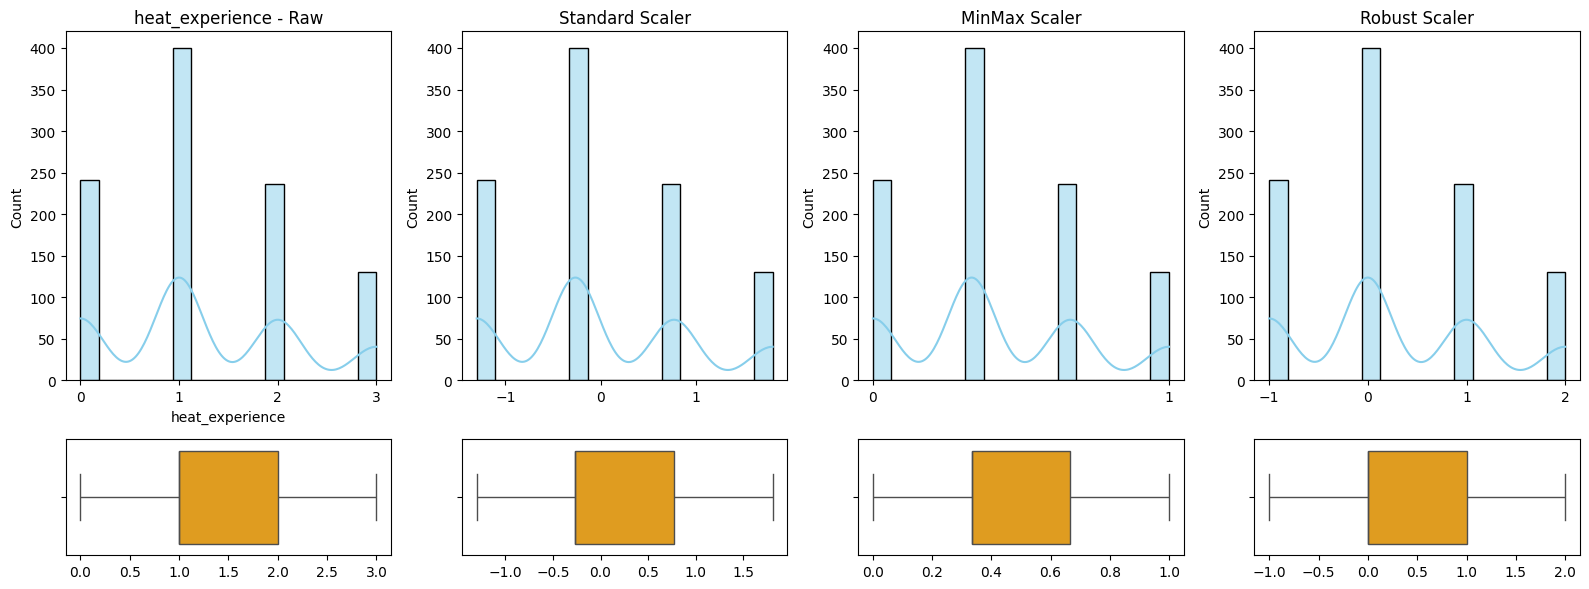

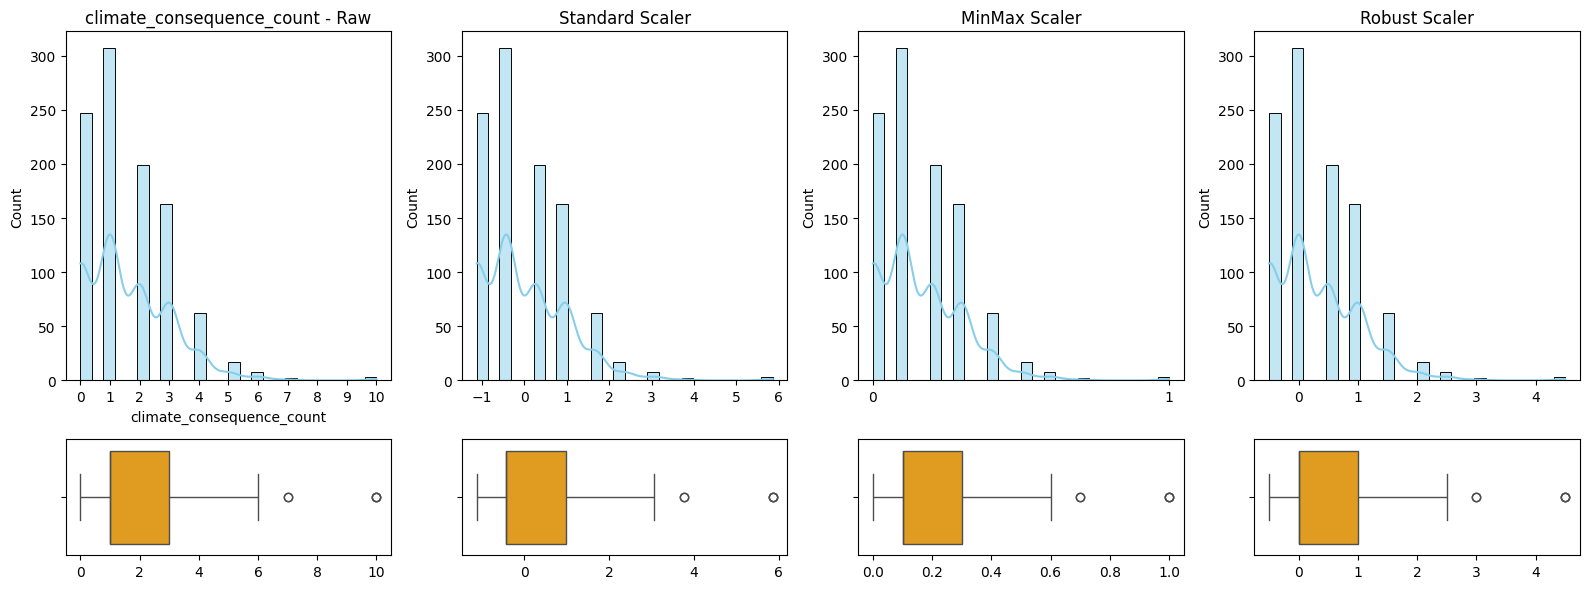

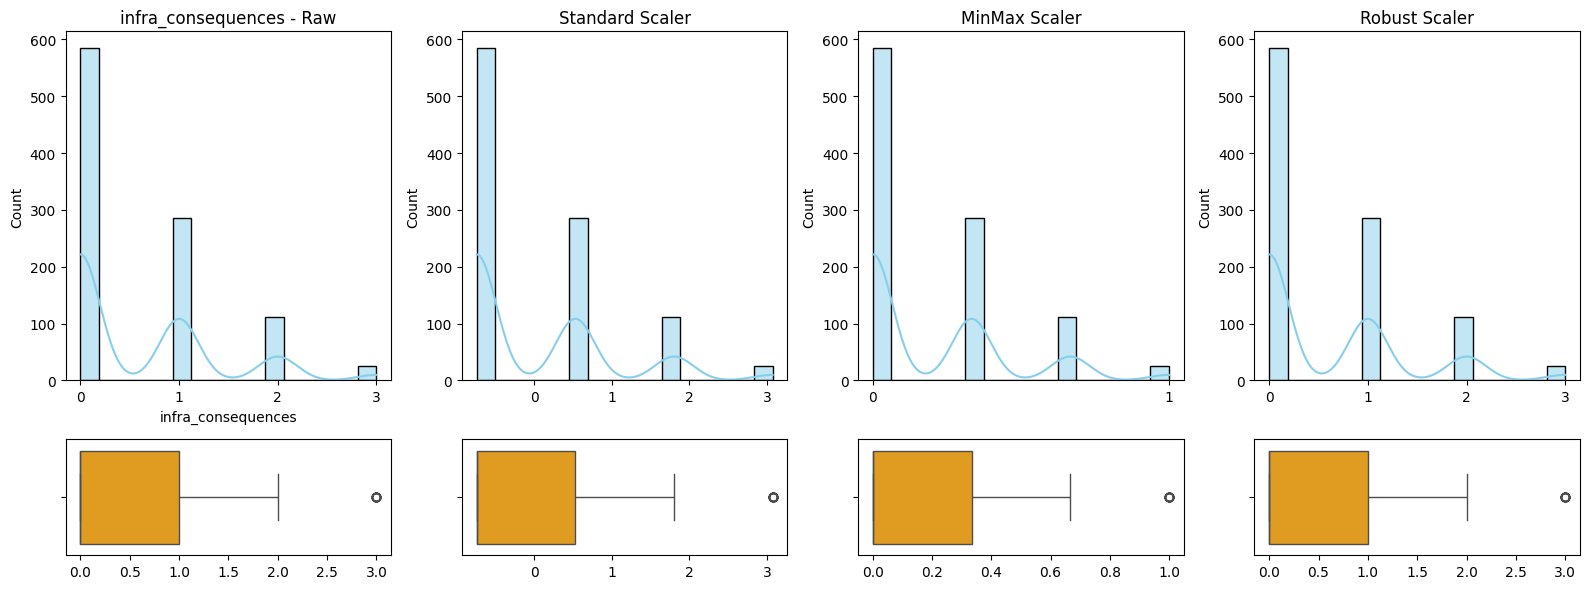

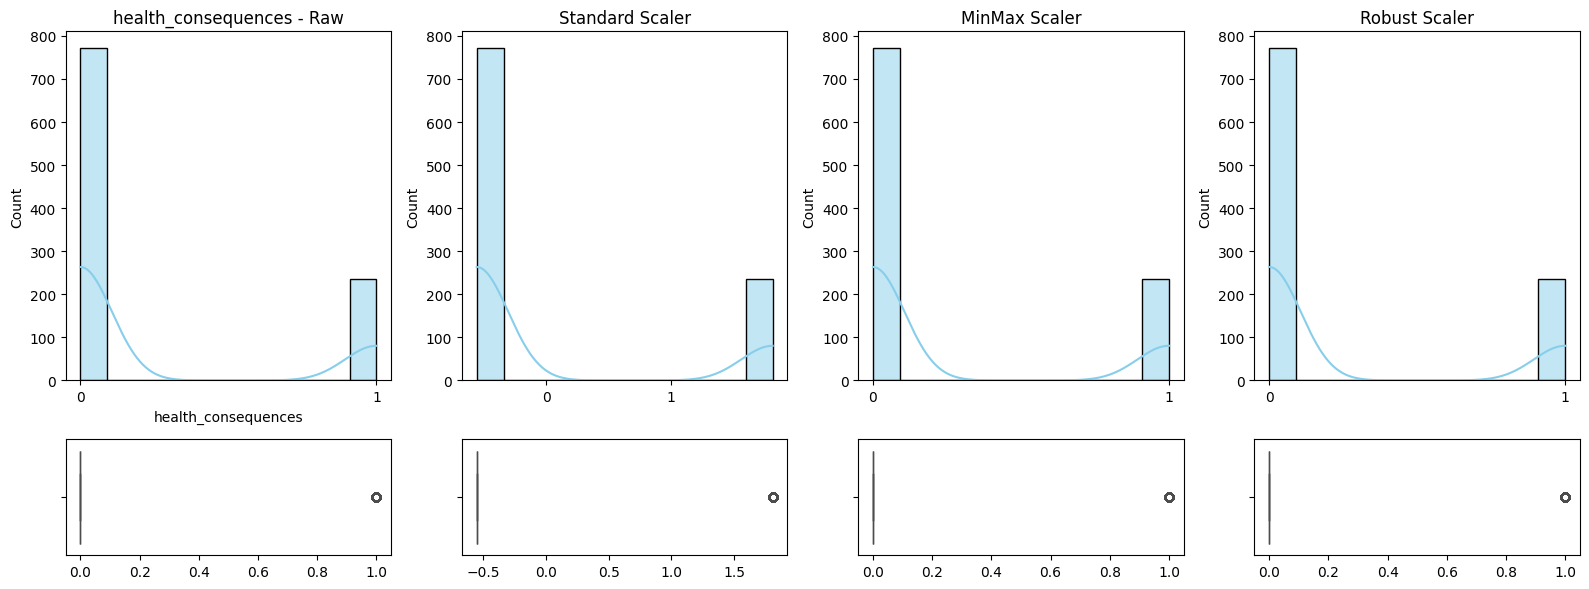

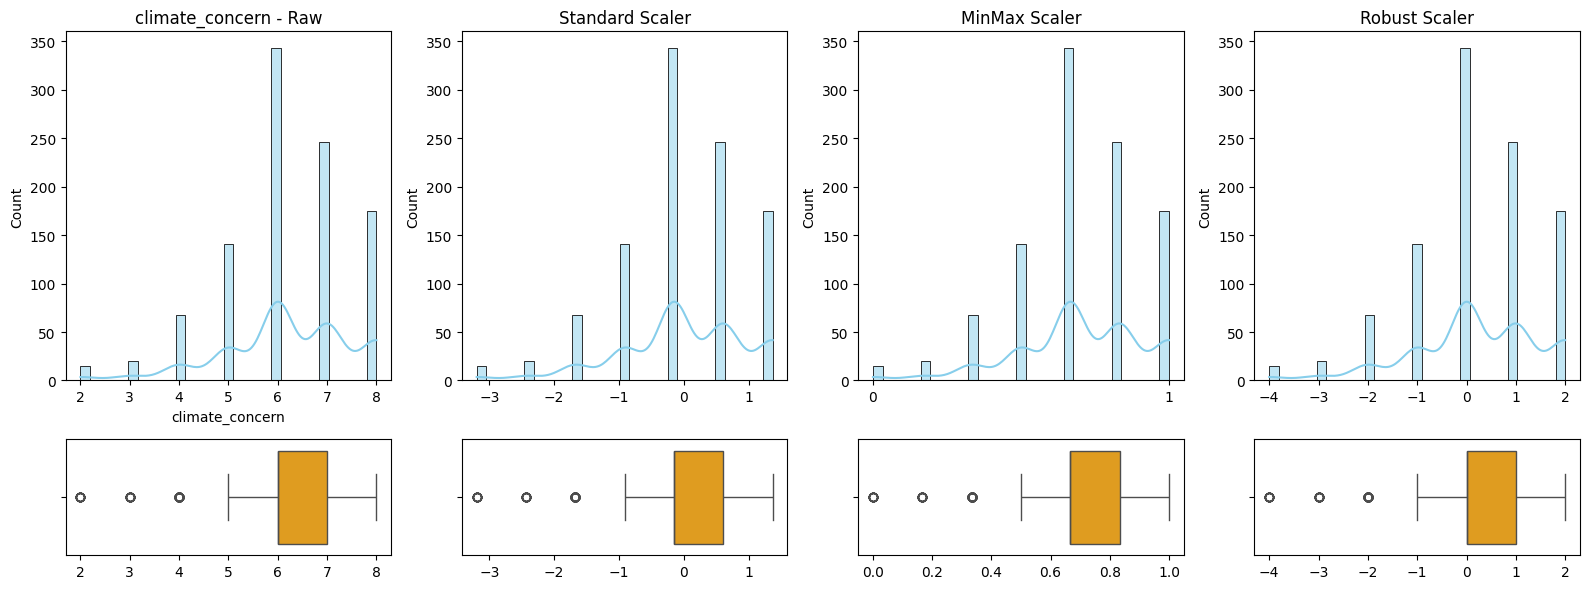

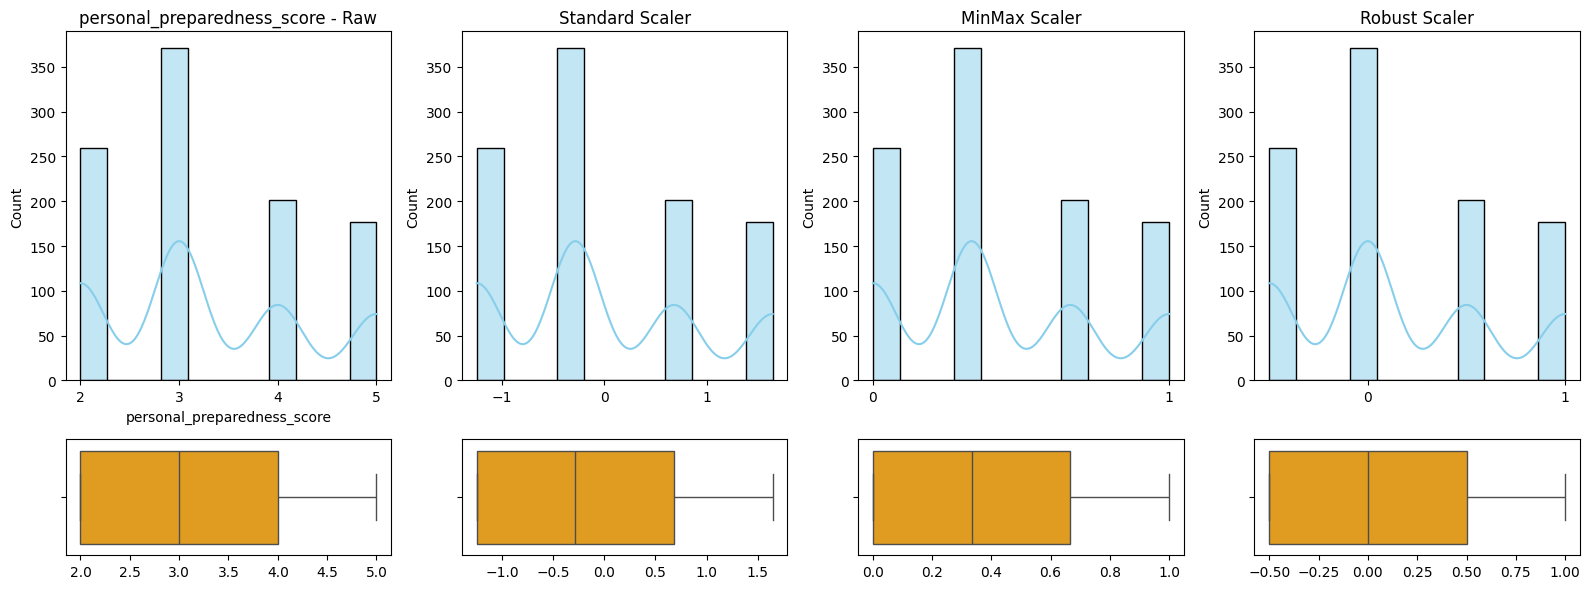

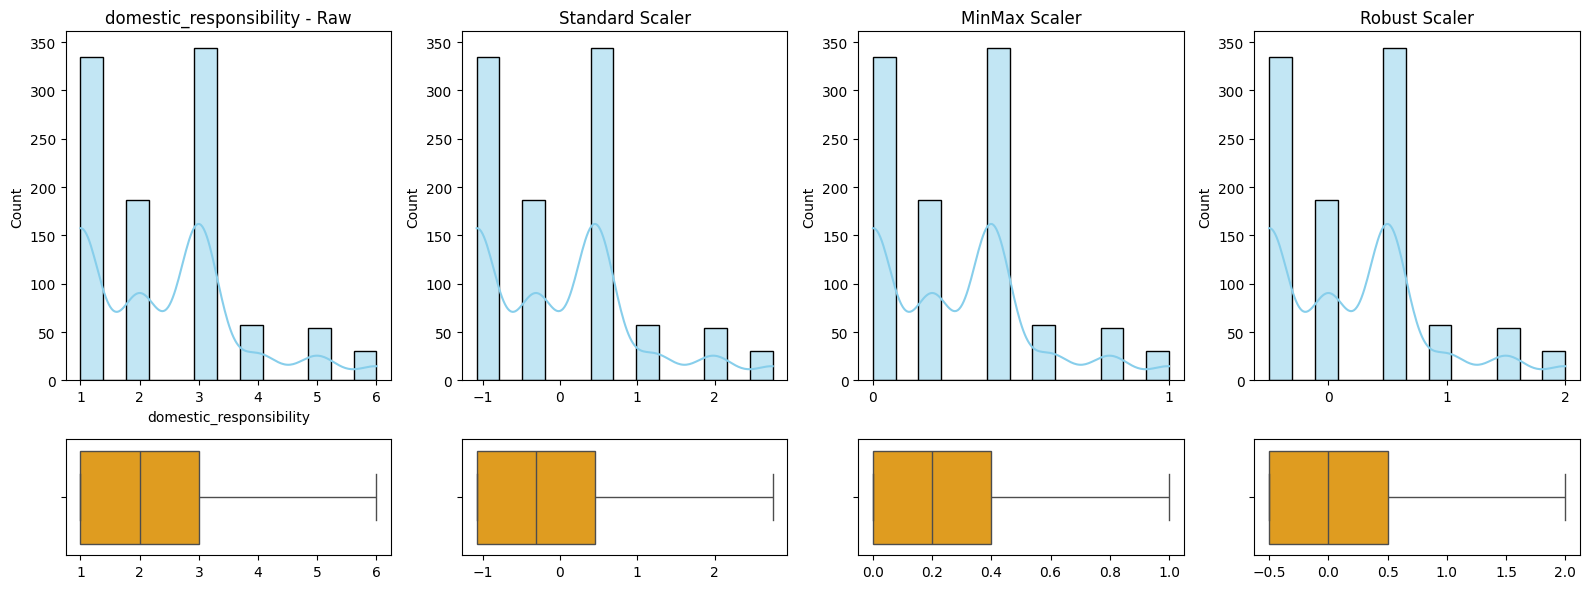

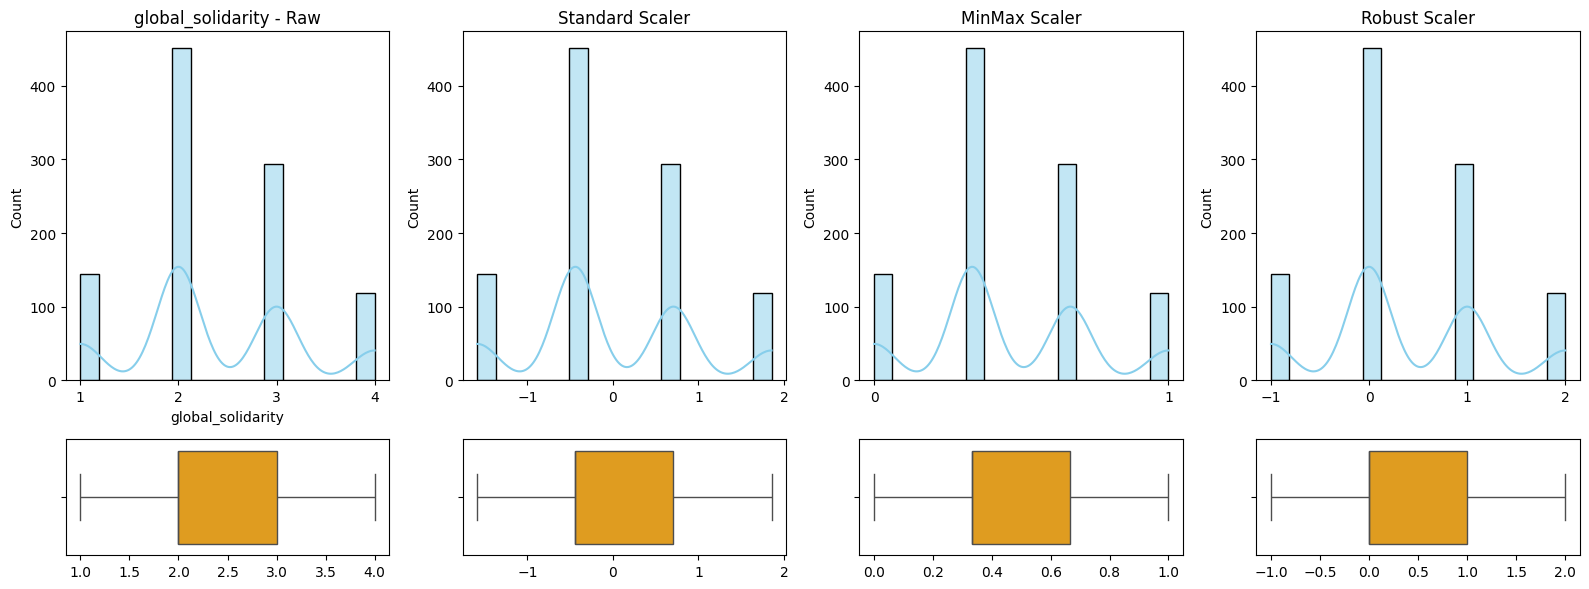

In [204]:
# Scaling cluster features
CLUSTER_FEATURES = cluster_df.columns.tolist()
scalers = {
    "Standard": StandardScaler(),
    "MinMax": MinMaxScaler(),
    "Robust": RobustScaler()
}

for col in CLUSTER_FEATURES:
    fig, axes = plt.subplots(2, 4, figsize=(16, 6), 
                             gridspec_kw={'height_ratios': [3, 1]})
    
    # raw
    sns.histplot(cluster_df[col], kde=True, ax=axes[0, 0], color="skyblue", edgecolor="black")
    axes[0, 0].set_title(f"{col} - Raw")
    sns.boxplot(x=cluster_df[col], ax=axes[1, 0], color="orange")
    axes[1, 0].set_xlabel("")
    
    if np.issubdtype(cluster_df[col].dtype, np.integer):
        axes[0, 0].xaxis.set_major_locator(mticker.MultipleLocator(1))

    # scaled
    for i, (name, scaler) in enumerate(scalers.items(), start=1):
        scaled = scaler.fit_transform(cluster_df[[col]])
        
        sns.histplot(scaled.ravel(), kde=True, ax=axes[0, i], color="skyblue", edgecolor="black")
        axes[0, i].set_title(f"{name} Scaler")
        
        if np.issubdtype(cluster_df[col].dtype, np.integer):
            axes[0, i].xaxis.set_major_locator(mticker.MultipleLocator(1))
        
        sns.boxplot(x=scaled.ravel(), ax=axes[1, i], color="orange")
        axes[1, i].set_xlabel("")
    
    plt.tight_layout()
    plt.show()


**Feature Scaling Strategy*

All clustering features in this dataset are derived from Likert-style questions or composite indices. This has several implications for preprocessing:

- **Bounded Scales:** Each variable is already constrained to a fixed range (e.g., 1–10, 1–5).  
- **No True Outliers:** Since response options were predefined, extreme values cannot occur beyond the original scale.  
- **Non-Normal Distributions:** Many variables show skewed or mixed shapes rather than symmetric, bell-like distributions.  
- **Comparable Measurement Nature:** All features represent subjective attitudes or experiences on ordered scales.

Given these conditions, **MinMax scaling** was applied uniformly across all numeric features. This choice ensures that:

1. Each feature is rescaled to the same [0,1] interval, preventing variables with larger numeric ranges from dominating the clustering process.  
2. The original distributional shapes are preserved, which is important for interpretability in downstream cluster profiling.  
3. Transparency is maintained, as MinMax scaling is straightforward to explain to non-technical audiences (cluster profiles can be directly read on a 0–1 scale).

Other options were considered:  
- *StandardScaler* would center and scale by variance, but the lack of normality and absence of variance-driven priorities made it less suitable.  
- *RobustScaler* is primarily used to reduce the influence of outliers, which are not present in bounded Likert data.

**Conclusion:** MinMax scaling provides the most appropriate balance between mathematical comparability and interpretability for this dataset.  

### 2.2 - FINAL DECISION ON SCALING

This was the final reasoning behind the preprocessing of the clustering features:  
   - Apply Yeo–Johnson transform to reduce skew (handles 0 and negative values) - it does very little but better than nothing
   - Apply MinMax scaler to put all features on comparable scale (features are not normally distributed)

In [205]:
# Apply Yeo-Johnson to reduce skew (same as before)
pt = PowerTransformer(method="yeo-johnson")
cluster_df_trans = pd.DataFrame(
    pt.fit_transform(cluster_df),
    columns=cluster_df.columns,
    index=cluster_df.index
)

# Apply MinMaxScaler to all cluster features
scaler = MinMaxScaler() 
#scaler = StandardScaler()
# scaler = RobustScaler()

# Standardize features using the same scaler as 
scaler = StandardScaler()
cluster_df_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_df_trans),
    columns=cluster_df.columns,
    index=cluster_df.index
)

### 2.3 - OUTLIER DETECTION

When it came to checking out for outliers, I explored three methods (and discarded Z-score as it works well for approximately normal distributions):

1. **IQR (Interquartile Range):**  
   - Captures values far from the 25th–75th percentile range.  
   - On strongly skewed survey-like data, it overestimates outliers.    

2. **MAD (Median Absolute Deviation):**  
   - Robust to skew in theory, but here it exaggerated even more: 63% flagged.   

3. **Isolation Forest:**  
   - Considers all variables simultaneously.  
   - Identifies ~5% as true anomalies based on isolation in multivariate space.    

**Side note**:
Scaling the data beforehand will not affect outlier detection. On the contrary it will help PCA later on as the main componenets will not be dominated by the features with larger ranges.

In [ ]:
# IQR method
def iqr_outliers(df):
    outlier_flags = pd.DataFrame(index=df.index)
    for col in df.columns:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outlier_flags[col] = (df[col] < lower) | (df[col] > upper)
    outlier_flags["n_outliers"] = outlier_flags.sum(axis=1)
    return (outlier_flags["n_outliers"] > 0)

iqr_flags = iqr_outliers(cluster_df_scaled)
print("IQR outliers:", iqr_flags.sum(), "/", len(cluster_df_scaled))

# MAD method
def mad_outliers(df, threshold=3.5):
    median = df.median()
    mad = (df - median).abs().median()
    modified_z = 0.6745 * (df - median).abs() / mad
    row_flags = (modified_z > threshold).any(axis=1)
    return row_flags

mad_flags = mad_outliers(cluster_df_scaled)
print("MAD outliers:", mad_flags.sum(), "/", len(cluster_df_scaled))

# Isolation Forest 
iso = IsolationForest(contamination=0.05, random_state=42)
iso_labels = iso.fit_predict(cluster_df_scaled)  # -1 = outlier, 1 = inlier
iso_flags = iso_labels == -1
print("Isolation Forest outliers:", iso_flags.sum(), "/", len(cluster_df_scaled))


IQR outliers: 333 / 1008
MAD outliers: 631 / 1008
Isolation Forest outliers: 51 / 1008


**Results**
- **IQR method (after Yeo–Johnson transform):** 376 outliers (≈37% of 1008) - a third of the dataset (37%) is flagged → indicates long-tailed distributions, not true anomalies.  
 
- **MAD method:** 631 outliers (≈63%) - Confirms that univariate methods struggle when many features are skewed.  

- **Isolation Forest:** 49 outliers (≈5%) - much more plausible: points flagged are genuinely isolated, not just in the tail of a skewed feature.  

**Reasoning**

- **Survey/likert-like features are bounded but skewed** → tails are part of the real phenomenon, not errors.  
- **Univariate methods (IQR, MAD)** → misleading, because they don’t capture multivariate relationships.  
- **Multivariate method (Isolation Forest)** → better suited, finds rare combinations of values rather than just extreme univariates.  

**Next steps**
- Save out both datasets `cluster_df_scaled` and `cluster_df_noOut`
- Apply dimensionality reduction on both clustering sets (with and without outliers) 
- Run clustering on both and compare results.

In [207]:
# Dataset without the 51 outliers
cluster_df_scaled_noOut = cluster_df.loc[~iso_flags].copy()
print("Shape without outliers:", cluster_df_scaled_noOut.shape)

Shape without outliers: (957, 12)


In [208]:
### 2.2 - EDA ON DESCRIPTIVE FEATURES 

In [209]:
display(desc_df)

,gender,age_group,kids,education,net_income,political_preference,housing_status,living_area
0,0,5,2,2,10,7,2,1
1,0,5,2,3,1,6,1,2
2,1,3,2,2,1,10,2,3
3,0,3,2,3,11,5,2,2
4,1,3,2,3,9,12,2,1
...,...,...,...,...,...,...,...,...
1003,0,4,2,3,10,8,2,1
1004,1,5,2,1,2,8,2,2
1005,1,5,2,3,10,2,2,1
1006,0,3,1,3,10,9,2,1


In [210]:
# Light EDA for descriptive features (not used for clustering)

# Define nominal and ordinal features
nominal_feats = [
    "gender",            # binary recoded (nominal)
    "kids",              # small ordinal/binary — treat nominal for profiling
    "housing_status",    # nominal
    "living_area"        # nominal / coarse ordinal — treat nominal for clarity
]

ordinal_feats = [
    "age_group",         # ordered
    "education",         # ordered
    "net_income",        # ordered brackets
    "political_preference"  # ordered left-right scale (with missing)
]

# print value count for each nominal feature
for feat in nominal_feats:
    print(f"Value counts for {feat}:")
    print(desc_df[feat].value_counts(dropna=False))
    print("\n")
# print value count for each ordinal feature
for feat in ordinal_feats:
    print(f"Value counts for {feat}:")
    print(desc_df[feat].value_counts(dropna=False).sort_index())
    print("\n")

Value counts for gender:
gender
1    542
0    466
Name: count, dtype: int64


Value counts for kids:
kids
2    732
1    276
Name: count, dtype: int64


Value counts for housing_status:
housing_status
2    754
1    214
3     40
Name: count, dtype: int64


Value counts for living_area:
living_area
2    481
1    369
3    158
Name: count, dtype: int64


Value counts for age_group:
age_group
1     54
2    124
3    350
4    238
5    242
Name: count, dtype: int64


Value counts for education:
education
1    126
2    506
3    376
Name: count, dtype: int64


Value counts for net_income:
net_income
1     124
2      53
3      67
4      57
5      53
6      76
7      85
8     120
9     109
10    143
11    121
Name: count, dtype: int64


Value counts for political_preference:
political_preference
1      56
2      60
3     101
4      78
5     184
6     122
7      84
8     103
9      54
10     53
11     71
12     42
Name: count, dtype: int64




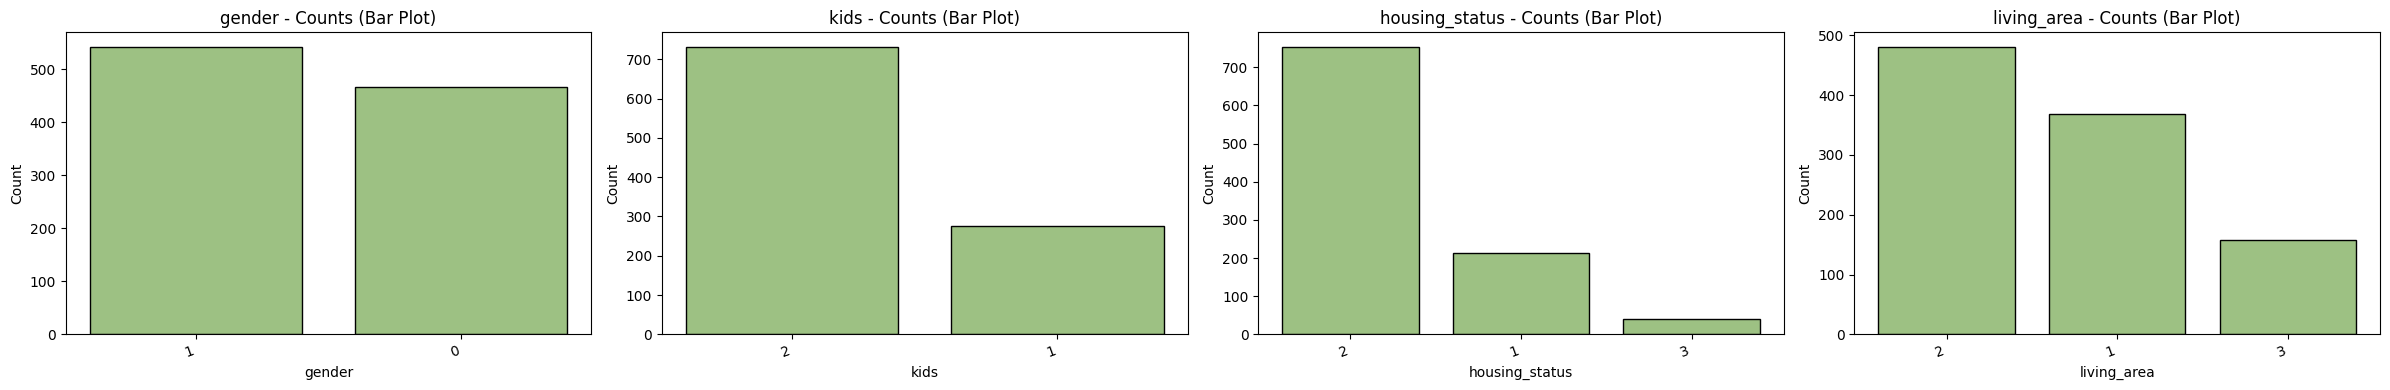

In [211]:
# Descriptive features - Nominal - Bar Plots

plt.rcParams.update({'figure.max_open_warning': 0})

n_cols = len(nominal_feats)
fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 4))

if n_cols == 1:
    axes = [axes]

for idx, col in enumerate(nominal_feats):
    vc = desc_df[col].value_counts(dropna=False)

    labels = vc.index.to_series().astype("string").fillna("NaN")
    x = np.arange(len(vc))

    ax = axes[idx]
    ax.bar(x, vc.values, color="#9DC183", edgecolor="black")
    ax.set_title(f"{col} - Counts (Bar Plot)")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=20, ha="right")

plt.tight_layout()
plt.show()


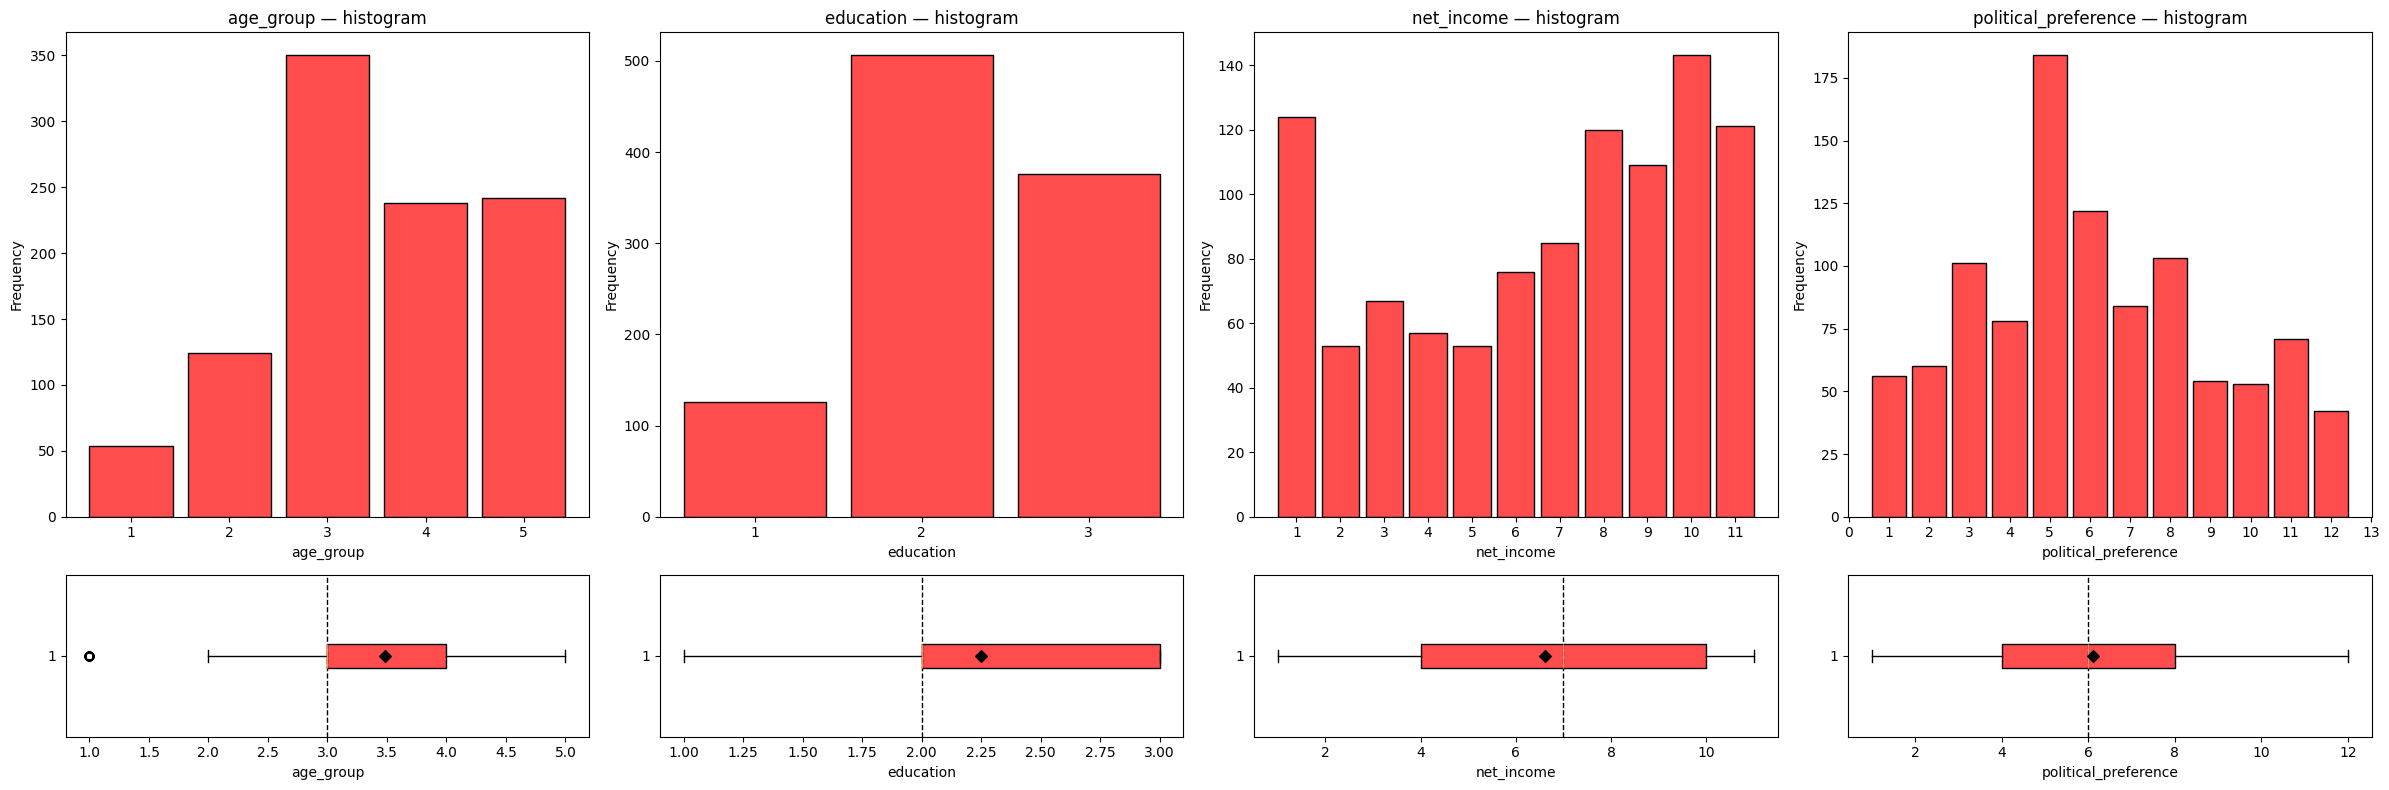

In [212]:
# Grid: histograms in row 0, boxplots in row 1
n_cols = len(ordinal_feats)
fig, axes = plt.subplots(2, n_cols, figsize=(6 * n_cols, 8),
                         gridspec_kw={'height_ratios': [3, 1]})

for idx, col in enumerate(ordinal_feats):
    s = desc_df[col].dropna()

    # integer-friendly bins
    if len(s) and np.issubdtype(s.dtype, np.number):
        mn, mx = int(s.min()), int(s.max())
        bins = np.arange(mn - 0.5, mx + 1.5, 1)
    else:
        bins = "auto"
        mn, mx = None, None

    # Histogram (top row)
    axes[0, idx].hist(
        s, bins=bins, color="#FF4C4C", rwidth=0.85, edgecolor="black"
    )
    axes[0, idx].set_title(f"{col} — histogram")
    axes[0, idx].set_xlabel(col)
    axes[0, idx].set_ylabel("Frequency")

    if mn is not None and mx is not None:
        axes[0, idx].xaxis.set_major_locator(mticker.MultipleLocator(1))

    # Boxplot (bottom row)
    axes[1, idx].boxplot(
        s, vert=False, patch_artist=True,
        boxprops=dict(facecolor="#FF4C4C", color="black", edgecolor="black")
    )
    axes[1, idx].set_xlabel(col)

    # Draw median line in black
    median_val = np.median(s)
    axes[1, idx].axvline(median_val, color="black", linestyle="--", linewidth=1)

    # Draw mean marker (diamond) in black
    mean_val = np.mean(s)
    axes[1, idx].scatter(mean_val, 1, color="black", marker="D", zorder=3)

plt.tight_layout()
plt.show()


### 2.5 - SAVE CLUSTERING DATASETS

In [213]:
# Save scaled clustering dataframe
utils.save_dataset(cluster_df_scaled, "01_climate_dataset_forClustering_scaled.xlsx", "processed")

# Save scaled clustering dataframe without outliers
utils.save_dataset(cluster_df_scaled_noOut, "01_climate_dataset_forClustering_scaled_noOutliers.xlsx", "processed")

# Save descriptive dataframe
utils.save_dataset(desc_df, "01_climate_dataset_descriptive_features.xlsx", "processed")

File saved as: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Clustering\Mapping_The_Italian_Climate_Mindscape\data\processed\01_climate_dataset_forClustering_scaled.xlsx
File saved as: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Clustering\Mapping_The_Italian_Climate_Mindscape\data\processed\01_climate_dataset_forClustering_scaled_noOutliers.xlsx
File saved as: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Clustering\Mapping_The_Italian_Climate_Mindscape\data\processed\01_climate_dataset_descriptive_features.xlsx


In [214]:
# Combine scaled cluster features with unscaled/encoded descriptive features
# For proper downstream use, descriptive features should be encoded/scaled as appropriate

# Example: One-hot encode nominal features, ordinal encode ordinal features
desc_encoded = desc_df.copy()

# One-hot encode nominal features (drop_first=False to keep all categories)
desc_encoded = pd.get_dummies(desc_encoded, columns=nominal_feats, drop_first=False)

# Optionally, MinMax scale ordinal features for comparability (except for those already 0-1)
ordinal_scaler = MinMaxScaler()
desc_encoded[ordinal_feats] = ordinal_scaler.fit_transform(desc_encoded[ordinal_feats])

# Concatenate scaled cluster features and encoded/scaled descriptive features
full_df = pd.concat([cluster_df_scaled, desc_encoded], axis=1)

# Save the combined dataframe
utils.save_dataset(full_df, "01_climate_dataset_full_scaled_encoded.xlsx", "processed")

File saved as: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Clustering\Mapping_The_Italian_Climate_Mindscape\data\processed\01_climate_dataset_full_scaled_encoded.xlsx
